TODO: 
* run tensorboard with callback, 
* save / load best model

In [1]:
from IPython.core.debugger import set_trace

In [2]:
import numpy as np
from numpy.random import seed
seed(1)
#display all values from array
np.set_printoptions(threshold=np.nan)
#display not in scientific format
np.set_printoptions(suppress=True)

from tensorflow import set_random_seed
set_random_seed(2)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
DATA_FREQUENCY = 500
SAMPLING_RATE = 5
FREQUENCY_TO_SAMPLING_RATIO = DATA_FREQUENCY // SAMPLING_RATE

In [4]:
from data_reader import read_data

(input, target, headers) = read_data(data_path='data', 
                                     sampling_rate=SAMPLING_RATE, 
                                     data_frequency=DATA_FREQUENCY)

Loaded input file: 1
Loaded input file: 2
Loaded input file: 3
Loaded input file: 4
Loaded input file: 5
Loaded input file: 6
Loaded input file: 7
Loaded input file: 8
Loaded input file: 9
Loaded input file: 10
Loaded input file: 11
Loaded input file: 12
Loaded input file: 13
Loaded input file: 14
Loaded input file: 15
Loaded input file: 16
Loaded input file: 17
Loaded input file: 18
Loaded input file: 19
Loaded input file: 20
Loaded input file: 21
Loaded input file: 22
Loaded input file: 23
Loaded input file: 24
Loaded input file: 25
Loaded input file: 26
Loaded input file: 27
Loaded input file: 28
Loaded input file: 29
Loaded input file: 30
Loaded input file: 31
Loaded input file: 32
Loaded input file: 33
Loaded input file: 34
Loaded input file: 35
Loaded input file: 36
Loaded input file: 37
Loaded input file: 38
Loaded input file: 39
Loaded input file: 40
Loaded input file: 41
Loaded input file: 42
Loaded input file: 43
Loaded input file: 44
Loaded input file: 45
Loaded input file: 

In [5]:
def normalize(x, y):
    scalers = {}
    for channel_number in range(x.shape[1]):
        scalers[channel_number] = StandardScaler()
        x[:, channel_number, :] = scalers[channel_number].fit_transform(x[:, channel_number, :]) 
    return x, y.astype(int)

In [6]:
from chunks_creator import prepare_chunks
from chunks_creator import flatten_chunks

(chunks_input, chunks_target) = prepare_chunks(input, 
                                               target, 
                                               chunk_size_in_seconds=4, 
                                               ratio=FREQUENCY_TO_SAMPLING_RATIO)
(x, y) = flatten_chunks(chunks_input, chunks_target)
x, y = normalize(x, y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10)

In [7]:
#callbacks
from keras import callbacks

callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_acc', 
        patience=4
    ),
    callbacks.ModelCheckpoint(
        filepath='best_model.h5', 
        monitor='val_loss', 
        save_best_only=True
    ),
#     callbacks.TensorBoard(
#         log_dir='logs',
#         histogram_freq=1
#     )
]

Using TensorFlow backend.


In [8]:
def plot_results(history):
    import matplotlib.pyplot as plt

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [9]:
def create_fully_connected_model(input_shape):
    model = Sequential()
    model.add(layers.Flatten(input_shape=input_shape))
    model.add(layers.Dense(1000, activation='relu'))
    model.add(layers.Dense(30, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

In [10]:
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=False, input_shape=input_shape))
    # model.add(Dropout(0.5))
    #model.add(LSTM(100))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [11]:
from keras.layers import Dense, Embedding, SimpleRNN

def create_simple_rnn_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(32, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.layers import LSTM
    
def create_conv_1D_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=6, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [30]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

input_shape = x_train.shape[1:]

# model = create_fully_connected_model(input_shape)
# model = create_lstm_model(input_shape)
# model = create_simple_rnn_model(input_shape)

model = create_conv_1D_model(input_shape)
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train,
                    y_train,
                    epochs=100,
                    batch_size=16,
                    callbacks=callbacks_list,
                    validation_split=0.05)

score = model.evaluate(x_test, y_test, batch_size=16)

Train on 1005 samples, validate on 53 samples
Epoch 1/100
1005/1005 [==============================] - 1s 624us/step - loss: 0.8864 - acc: 0.5542 - val_loss: 0.6459 - val_acc: 0.6415
Epoch 2/100
1005/1005 [==============================] - 0s 265us/step - loss: 0.6573 - acc: 0.6746 - val_loss: 0.5710 - val_acc: 0.8302
Epoch 3/100
1005/1005 [==============================] - 0s 288us/step - loss: 0.6106 - acc: 0.6955 - val_loss: 0.5931 - val_acc: 0.7358
Epoch 4/100
1005/1005 [==============================] - 0s 292us/step - loss: 0.5891 - acc: 0.7323 - val_loss: 0.5716 - val_acc: 0.7925
Epoch 5/100
1005/1005 [==============================] - 0s 303us/step - loss: 0.5222 - acc: 0.7582 - val_loss: 0.5107 - val_acc: 0.7736
Epoch 6/100
118/118 [==============================] - 0s 153us/step


Accuracy: 77.97%


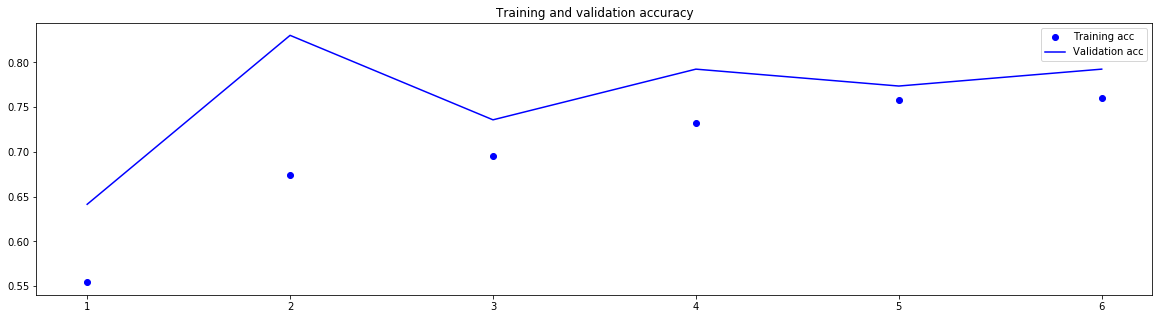

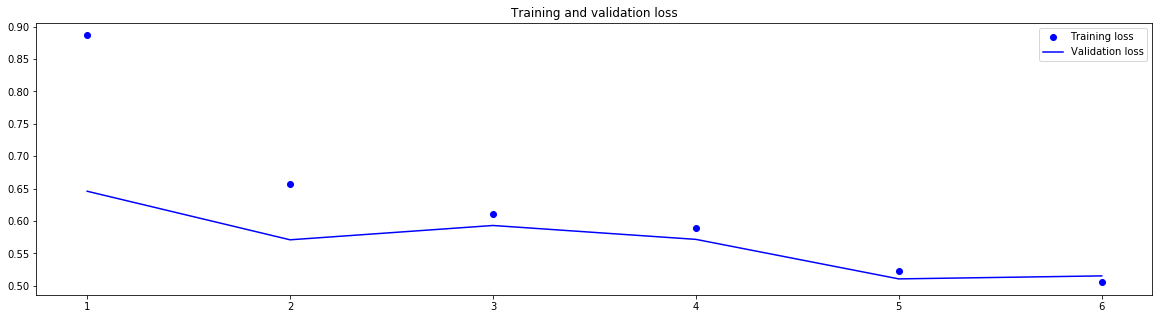

In [31]:
print("Accuracy: %.2f%%" % (score[1]*100))
plot_results(history)

In [15]:
from plots_printer import draw_plots, draw_plots_with_chunks

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]

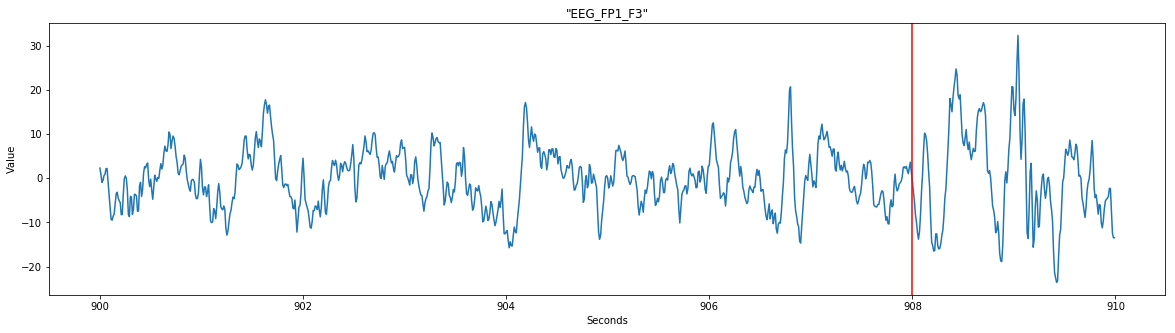

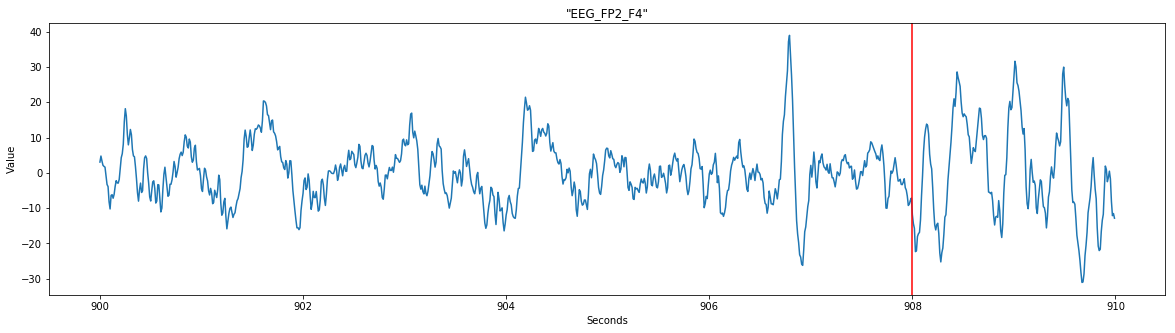

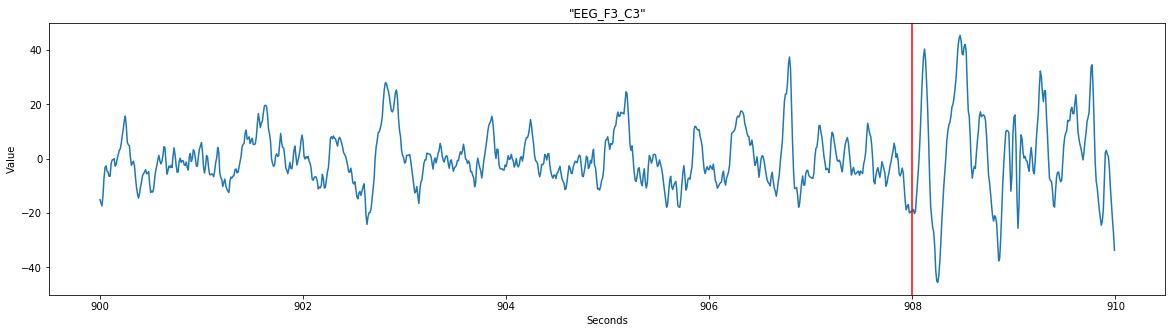

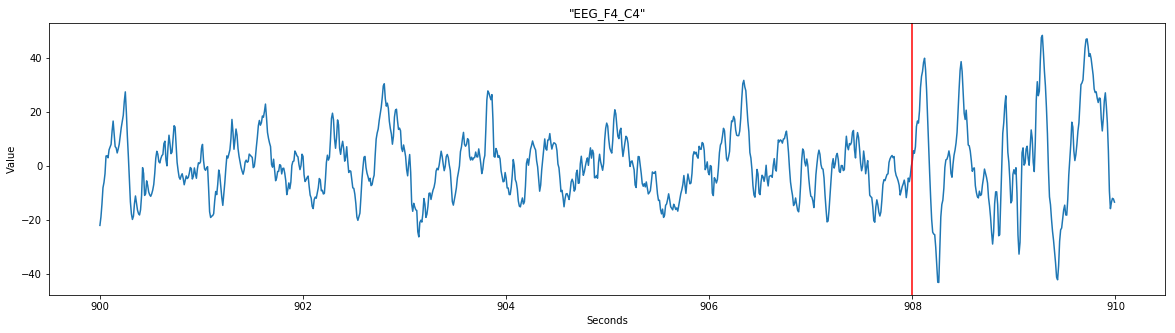

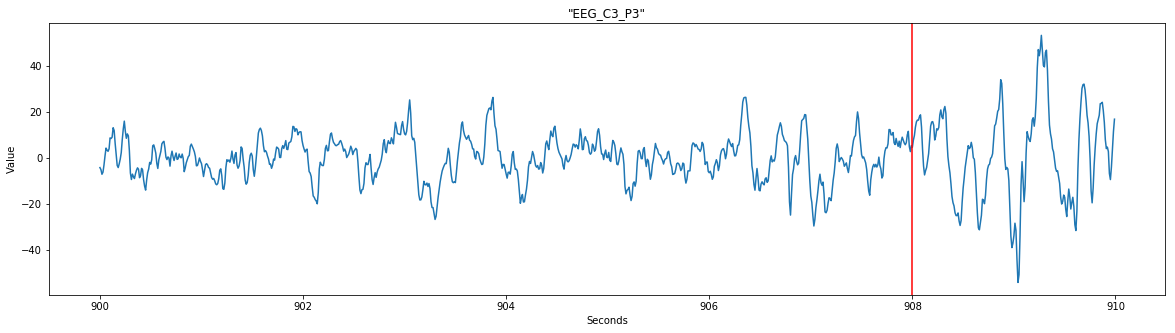

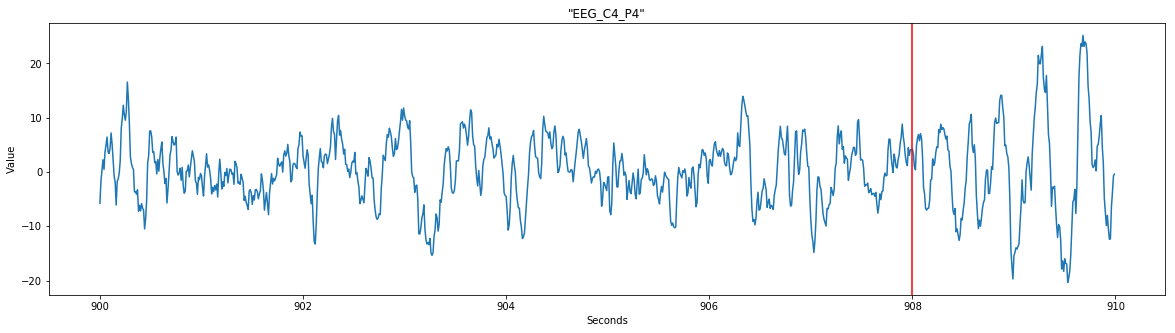

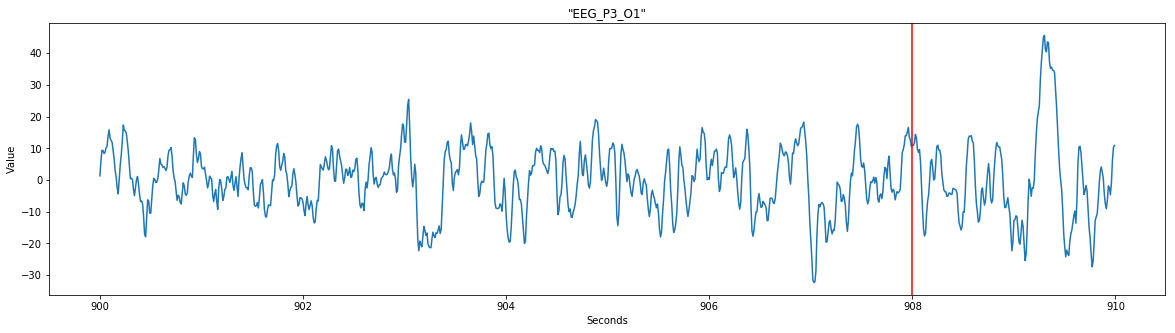

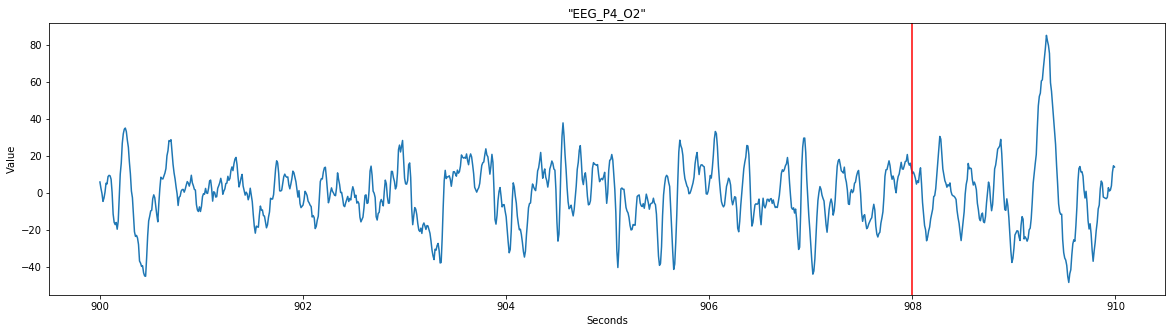

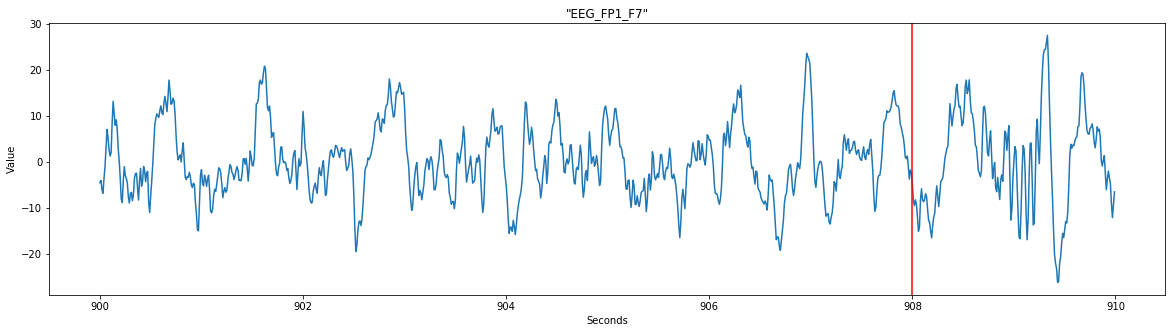

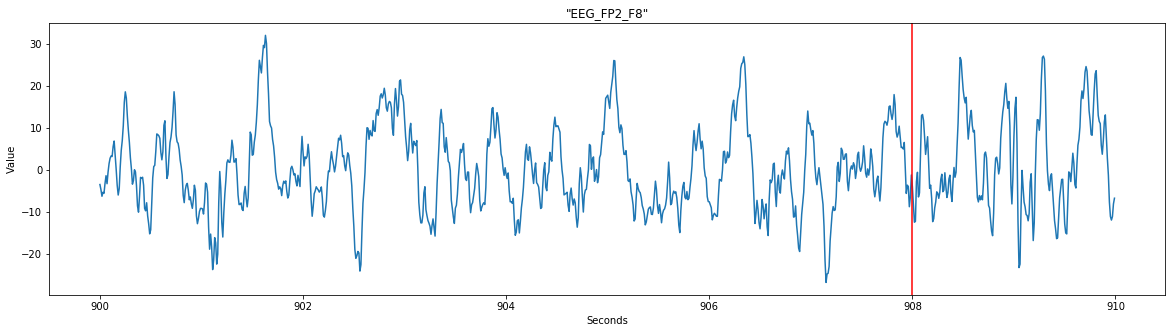

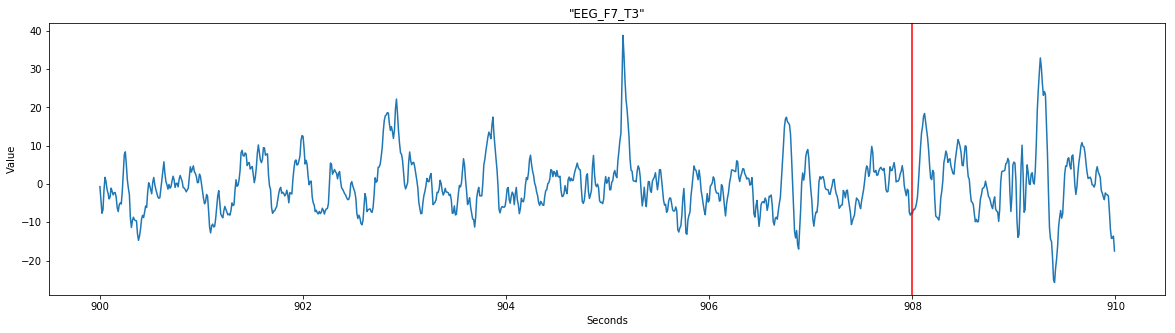

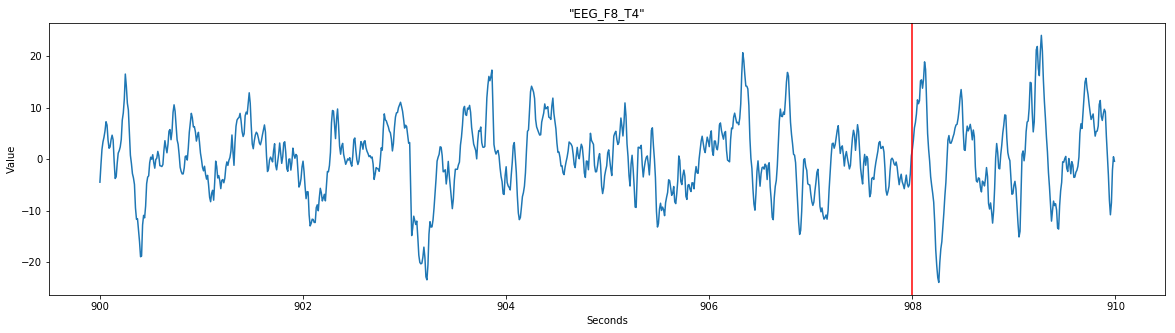

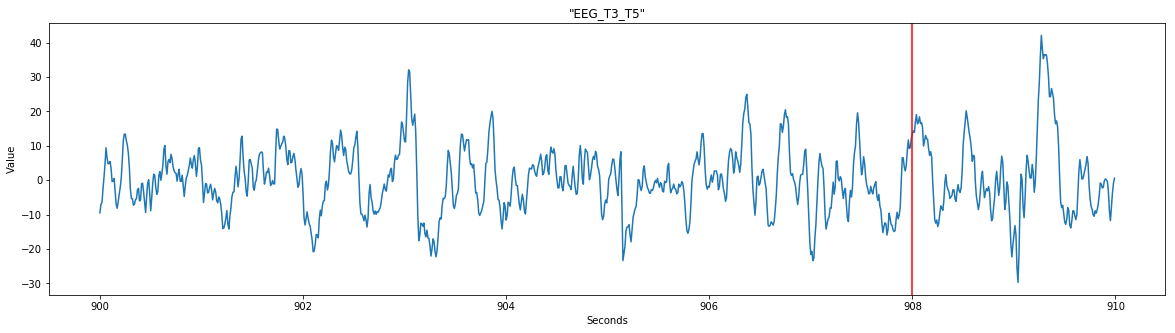

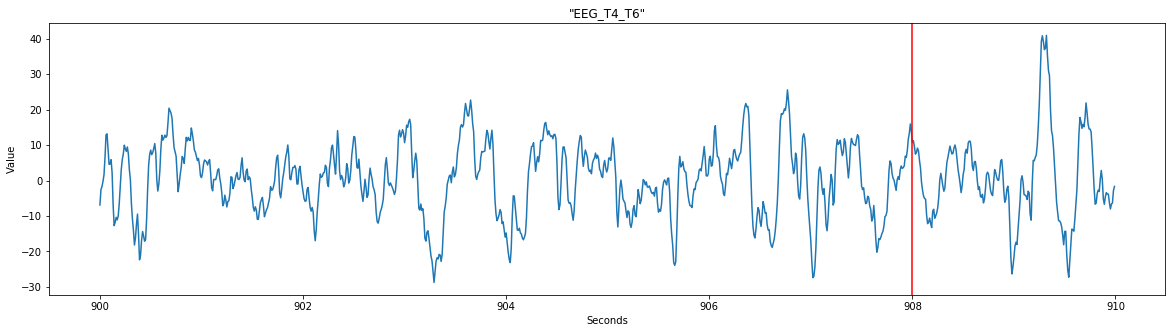

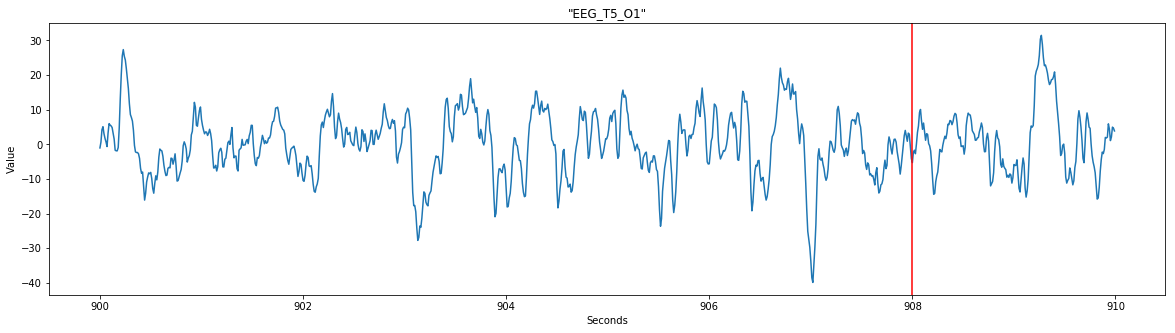

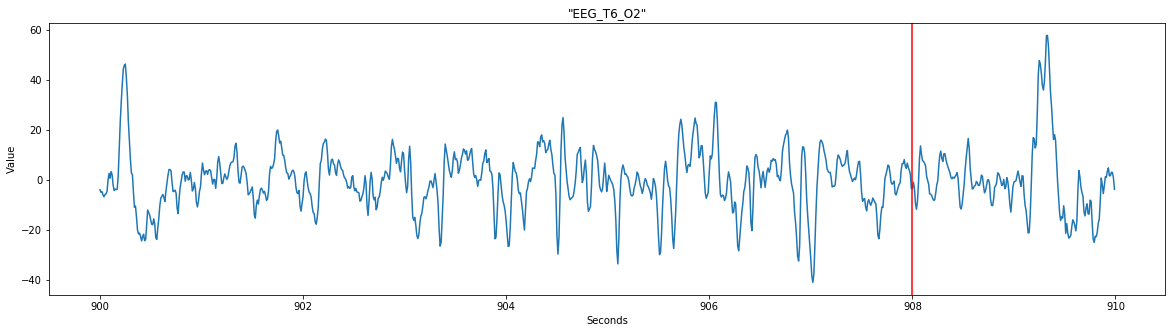

In [16]:
draw_plots(input, 
           target, 
           headers, 
           patient=0, 
           start_second=900, 
           end_second=910,
           ratio=FREQUENCY_TO_SAMPLING_RATIO)

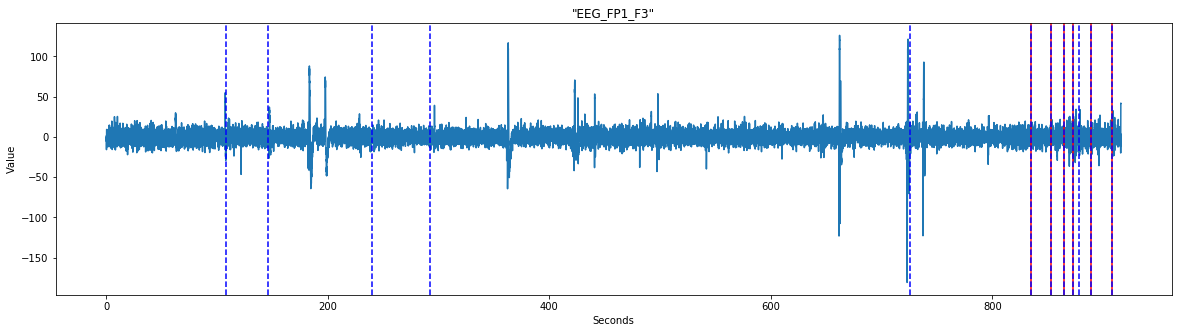

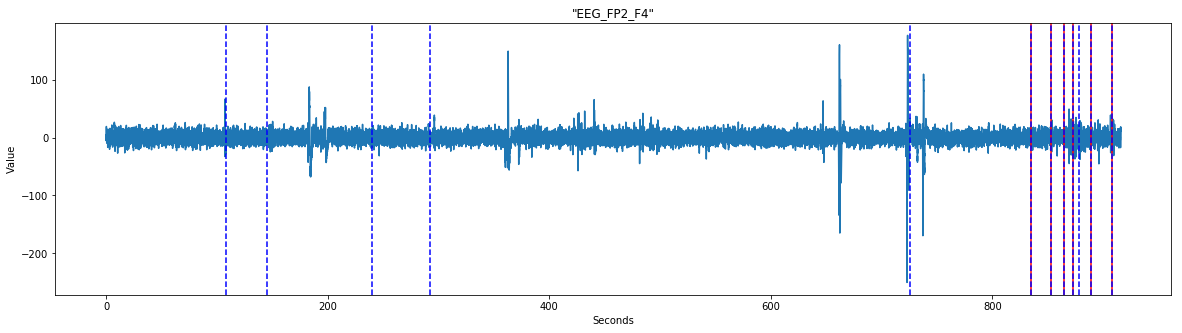

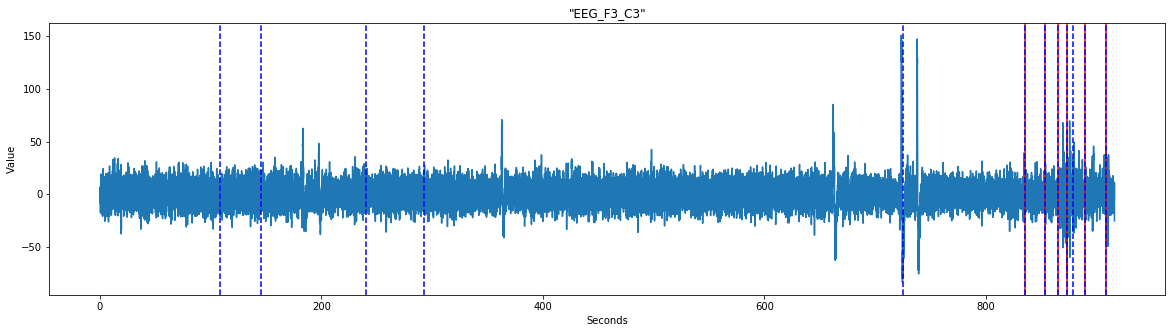

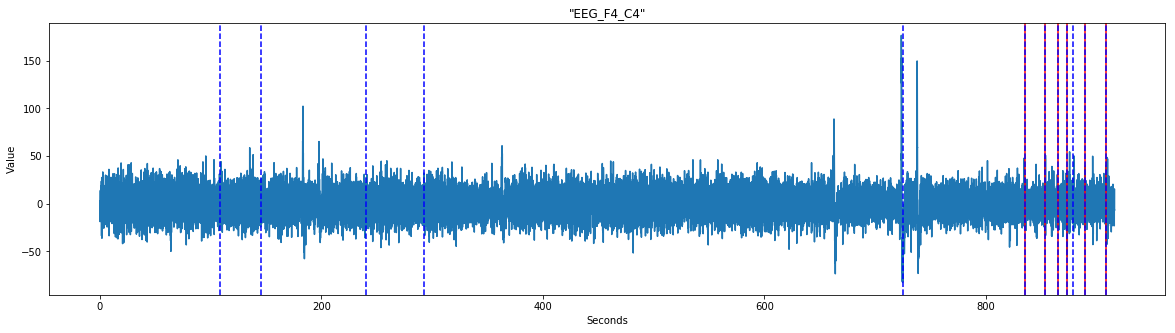

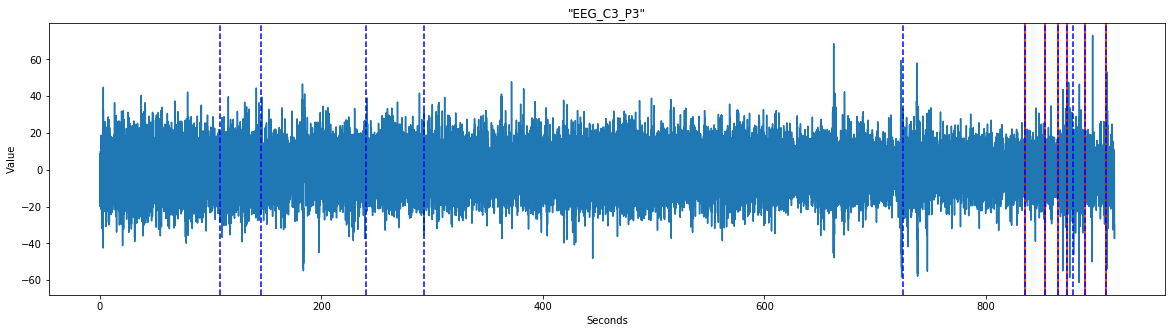

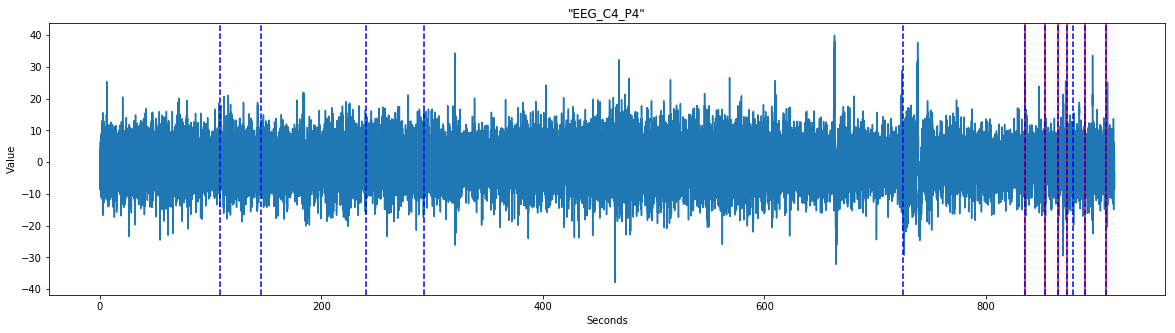

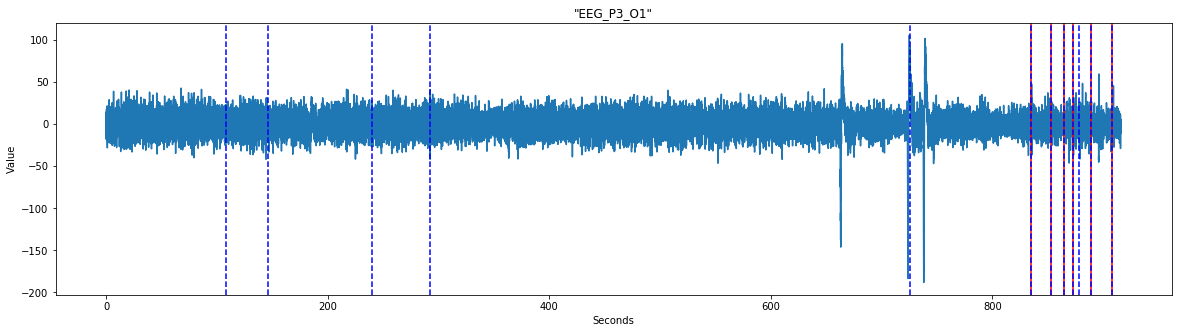

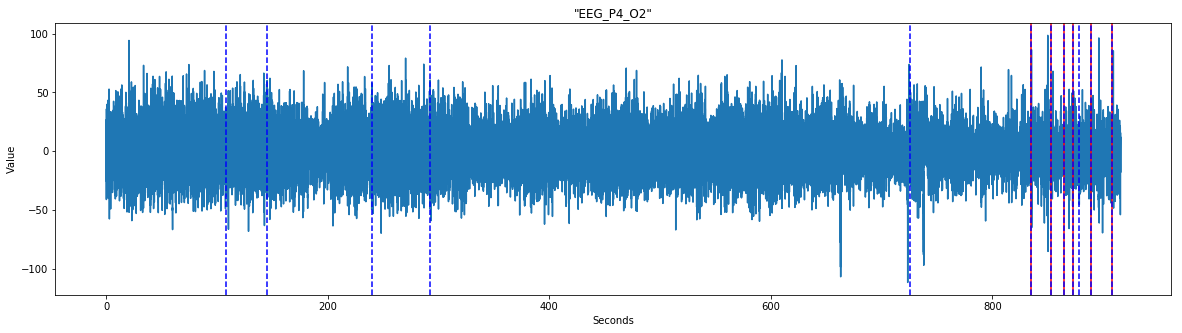

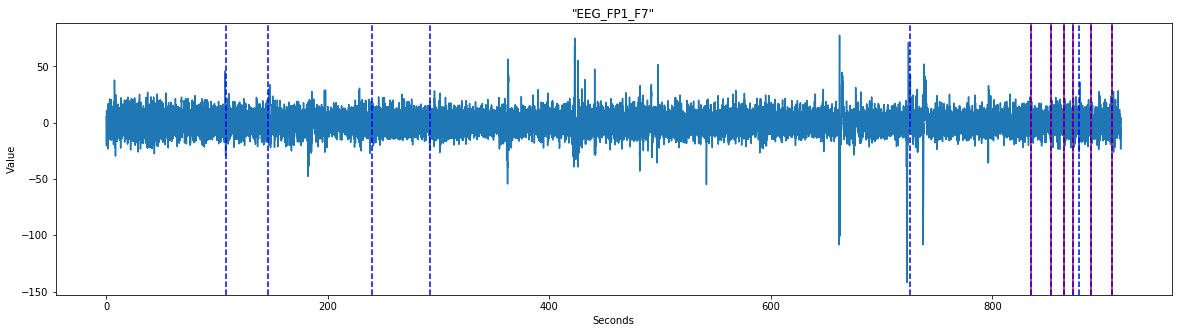

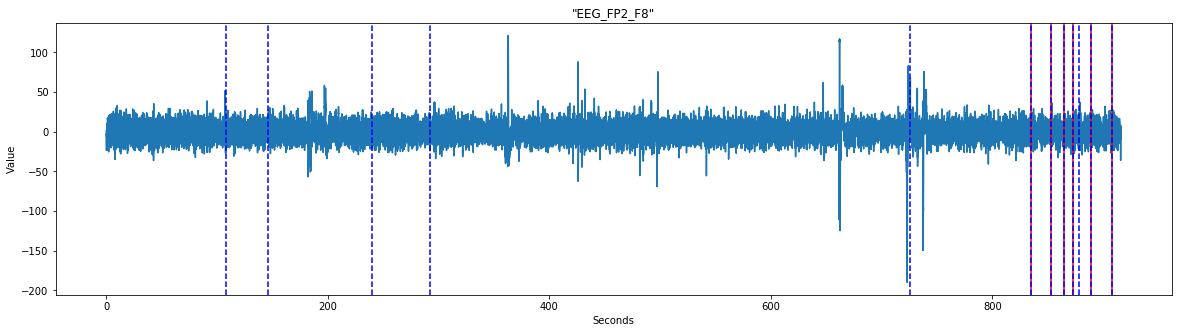

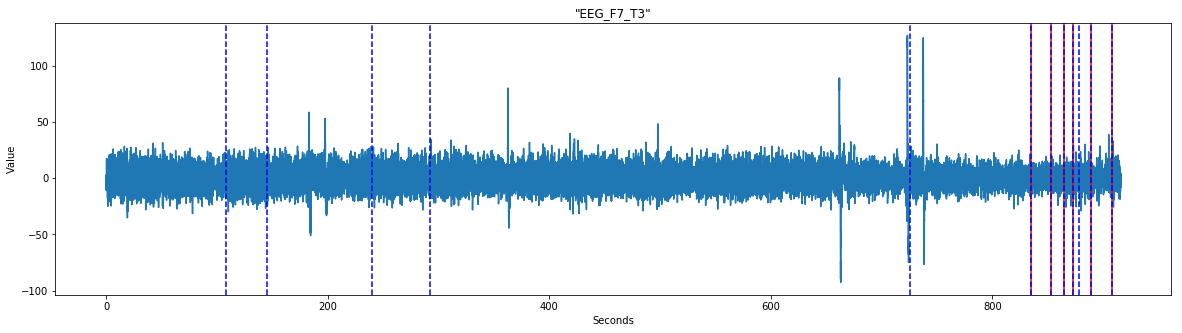

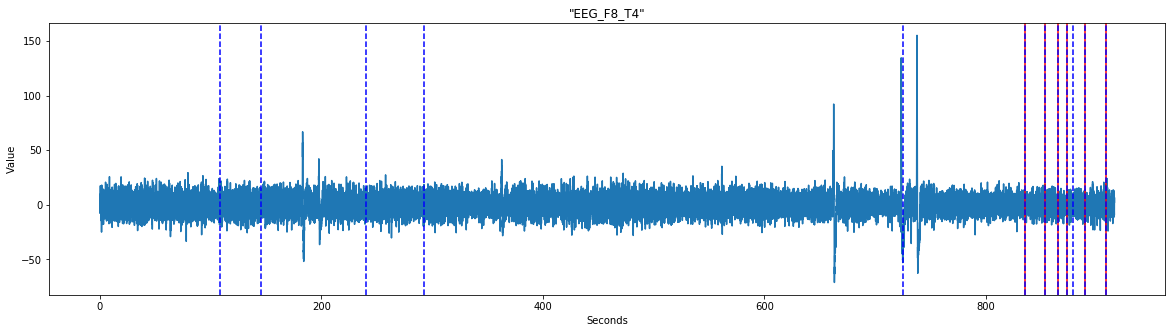

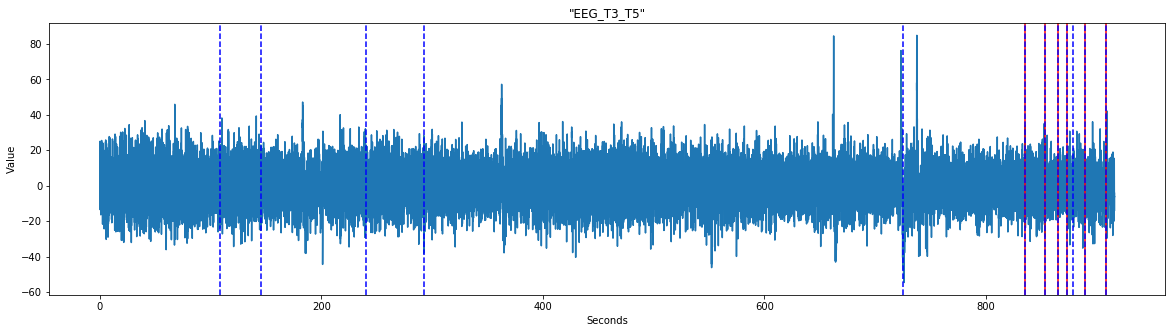

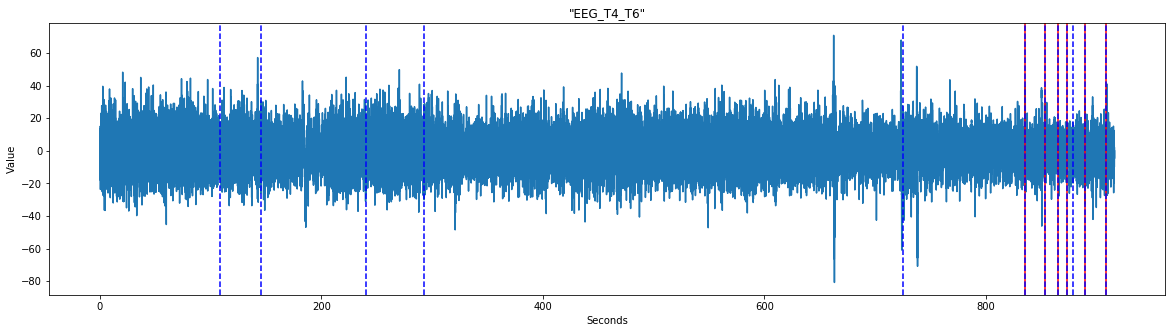

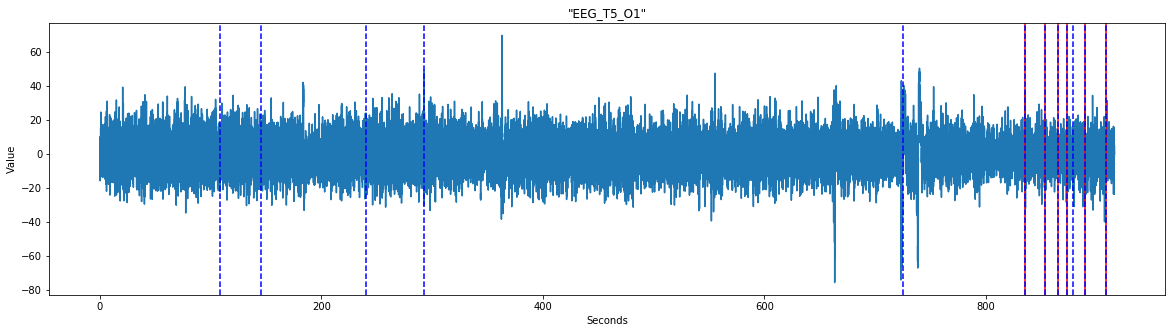

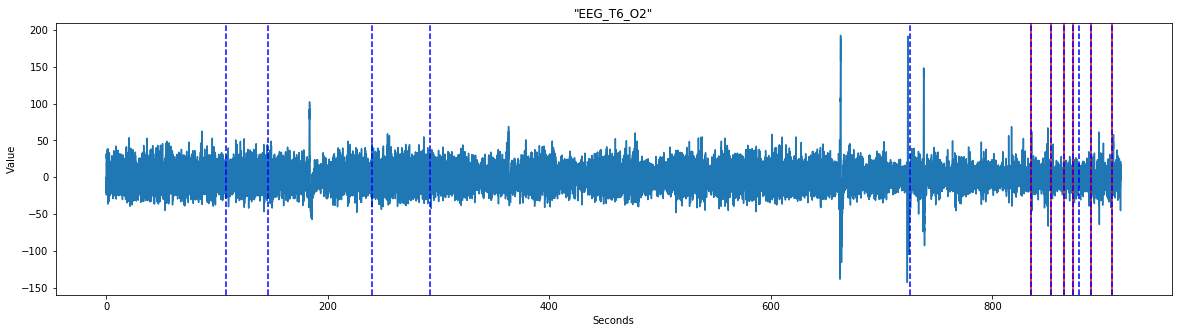

In [17]:
draw_plots_with_chunks(input, target, headers, patient=0, chunks_input = chunks_input, to_pdf=False)